### Задание

Попробуйте поработать с датасетом юридических текстов. В датасете всего две важных колонки признаков: заголовок дела и его текст, а целевая переменная - case_outcome (мультиклассовая классификация).

В базовом варианте можно оставить только текст дела, если хотите поинтереснее - можно попробовать распарсить case_title, добыв оттуда дополнительные признаки.

https://www.kaggle.com/datasets/amohankumar/legal-text-classification-dataset

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [11]:
data = pd.read_csv('legal_text_classification.csv')
data.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


#### Исследование данных

Структура датасета:

*   case_title — это по сути объект цитирования
*   case_text — это контекст, в котором оценивается это дело
*   case_outcome — тип ссылки: как это дело использовано в тексте (в другом деле)



**Задача**: классифицировать case_outcome на основе case_text (как задачу NLP)

Попробую использовать case_title как якорь для поиска позиции в тексте

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_id       24985 non-null  object
 1   case_outcome  24985 non-null  object
 2   case_title    24985 non-null  object
 3   case_text     24809 non-null  object
dtypes: object(4)
memory usage: 780.9+ KB


In [13]:
data.dropna(subset=['case_text'], inplace=True)

In [14]:
data.duplicated().sum() # дубликатов нет

np.int64(0)

In [15]:
data.case_outcome.unique()

array(['cited', 'applied', 'followed', 'referred to', 'related',
       'considered', 'discussed', 'distinguished', 'affirmed', 'approved'],
      dtype=object)

In [16]:
data.case_outcome.value_counts()

,count
case_outcome,
cited,12110
referred to,4363
applied,2438
followed,2252
considered,1699
discussed,1018
distinguished,603
related,112
approved,108


#### Про цитирование

In [17]:
data['title_in_text'] = data.apply(lambda row: int(row['case_title'] in row['case_text']), axis=1)

In [18]:
data.head()

,case_id,case_outcome,case_title,case_text,title_in_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...,1
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...,1
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...,0
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...,0
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...,1


In [19]:
data[data['title_in_text'] == 0]['case_outcome'].unique()

array(['cited', 'followed', 'related', 'referred to', 'considered',
       'distinguished', 'applied', 'discussed', 'affirmed', 'approved'],
      dtype=object)

In [20]:
data[data['title_in_text'] == 1]['case_outcome'].unique()

array(['cited', 'applied', 'followed', 'referred to', 'related',
       'considered', 'discussed', 'distinguished', 'affirmed', 'approved'],
      dtype=object)

In [22]:
data[data['title_in_text'] == 0].loc[3].case_title

'Dais Studio Pty Ltd v Bullett Creative Pty Ltd [2008] FCA 42'

In [21]:
data[data['title_in_text'] == 0].loc[3].case_text # цитирование есть, но не полное совпадение из-за опечатки

'The general principles governing the exercise of the discretion to award indemnity costs after rejection by an unsuccessful party of a so called Calderbank letter were set out in the judgment of the Full Court in Black v Lipovac [1998] FCA 699 ; (1998) 217 ALR 386. In summary those principles are: 1. Mere refusal of a "Calderbank offer" does not itself warrant an order for indemnity costs. In this connection it may be noted that Jessup J in Dais Studio Pty Ltd v Bullet Creative Pty Ltd [2008] FCA 42 said that (at [6]): if the rejection of such an offer is to ground a claim for indemnity costs, it must be by reason of some circumstance other than that the offer happened to comply with the Calderbank principle. 2. To obtain an order for indemnity costs the offeror must show that the refusal to accept it was unreasonable. 3. The reasonableness of the conduct of the offeree is to be viewed in the light of the circumstances that existed when the offer was rejected.'

#### Обучение классификационной модели

In [33]:
import nltk
from rapidfuzz import fuzz
nltk.download('punkt_tab')

def extract_context_snippet(row, window=2, threshold=90):
    title = row['case_title']
    text = row['case_text']

    if pd.isnull(text) or pd.isnull(title):
        return ''

    sentences = nltk.sent_tokenize(text)
    title_clean = title.lower()

    for i, sent in enumerate(sentences):
        score = fuzz.partial_ratio(title_clean, sent.lower())
        if score >= threshold:
            start = max(i - window, 0)
            end = min(i + window + 1, len(sentences))
            return ' '.join(sentences[start:end])

    return text

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [34]:
data['context_snippet'] = data.apply(extract_context_snippet, axis=1)

In [35]:
data.sample(3)

,case_id,case_outcome,case_title,case_text,title_in_text,context_snippet
19735,Case19911,cited,Baird Textiles Holdings Limited v Marks &amp; ...,The position is effectively captured in the fo...,1,The position is effectively captured in the fo...
7557,Case7624,cited,"Rahman v Secretary, Department of Education, E...","4 November 2008, Cowdroy J delivered judgment ...",0,"4 November 2008, Cowdroy J delivered judgment ..."
20339,Case20524,cited,Dare v Pulham [1982] HCA 70 ; (1982) 148 CLR 658,The principles governing the exercise of the C...,1,"It is not necessary to restate, at length, his..."


In [36]:
data.loc[18245].case_text, data.loc[18245].context_snippet

("course, the usual rule is that costs follow the event in the absence of special circumstances justifying some other order ( Hughes v Western Australian Cricket Association (Inc) (1986) ATPR 40-748 , Bowen Investments Pty Ltd v Tabcorp Holdings Ltd (No 2) [2008] FCAFC 107). The first and second respondents were unsuccessful in respect of their notice of motion. However, for very different reasons, the parties have submitted that the usual rule as to costs should not be perfunctorily applied in relation to this notice of motion. In summary: The first and second respondents have submitted that: the parties' costs of the hearings on 8 December 2008 and 20 February 2009 be costs of the notice of motion; and because, of three clear issues identified in the notice of motion, Mrs Tracy was successful in relation to two, the first and second respondents should pay one-third of Mrs Tracy's costs on a party and party basis. Mrs Tracy has submitted that: there is no question that Mrs Tracy was w

In [37]:
# vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 3),
    stop_words='english',
    min_df=2,  # игнорирование редких слов
    max_df=0.9  # игнорирование слишком частых
)
X = vectorizer.fit_transform(data['context_snippet'])

y = pd.Categorical(data['case_outcome']).codes

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
params = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced'],
    'max_iter': [1000, 2000]
}

# Модель и кросс-валидация
model = LinearSVC(dual=False, random_state=42)  # dual=False при n_samples > n_features
grid = GridSearchCV(model, params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Лучшие параметры: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}


              precision    recall  f1-score   support

           0       0.64      0.70      0.67        23
           1       0.33      0.32      0.33       496
           2       0.32      0.29      0.30        21
           3       0.70      0.69      0.70      2440
           4       0.31      0.31      0.31       353
           5       0.26      0.26      0.26       206
           6       0.38      0.36      0.37       110
           7       0.36      0.40      0.38       437
           8       0.53      0.55      0.54       855
           9       0.38      0.38      0.38        21

    accuracy                           0.55      4962
   macro avg       0.42      0.43      0.42      4962
weighted avg       0.55      0.55      0.55      4962

F1-weighted: 0.55


<Axes: >

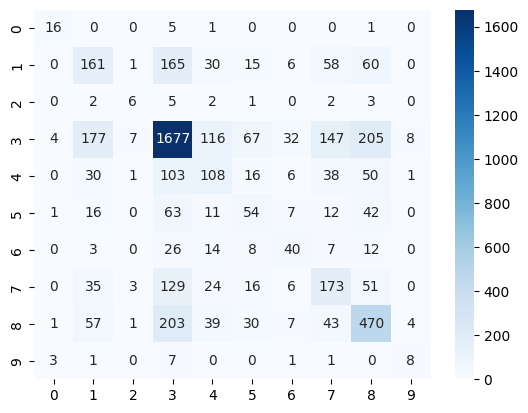

In [45]:
# Предсказание на тестовых данных
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

# Взвешенный F1
print(f"F1-weighted: {f1_score(y_test, y_pred, average='weighted'):.2f}")

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')